## **Team Electric**

## **Part 1: Data Preprocessing**

**Connect to Snowflake**

In [ ]:
#Install snowflake connector: pip install snowflake-connector-python
#pip install --upgrade snowflake-connector-python
from snowflake.connector.pandas_tools import write_pandas # type: ignore
import snowflake.connector as snow
import pandas as pd
import re
import os
from tqdm import tqdm
import numpy as np

# Be aware that MFA will be triggered
print("Connecting, please check for any MFA notifications.")

# Create a snowflake connection
conn = snow.connect(
# user="chulhee_kim", # Replace with your username
# password="Jkjk992499!!", # Replace with your password
# account="jdb11657.us-east-1",
# warehouse="DEFAULT_WAREHOUSE",
# database="CLASS_DTABASE",
# schema="ANALYSIS")
user = "siri_du",
password = "Snowflake_1212",
account="jdb11657.us-east-1",
warehouse="DEFAULT_WAREHOUSE",
database="CLASS_DATABASE",
schema="ANALYSIS")

Connecting, please check for any MFA notifications.


**Data Pre-Processing with SQL**
1. Drop conversation start with OUT direction (i.e. Agent to User messages)
2. Drop conversation with one direction (i.e. conversations that were initiated but never continued)

In [60]:
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS CLEAN_DATA_Final as( 
WITH first_messages AS (
    -- Identify the first message in each conversation
    SELECT 
        CONVERSATION_ID,
        MESSAGE_ID,
        MESSAGE,
        MESSAGE_DIRECTION,
        SENT_AT,
        ROW_NUMBER() OVER (PARTITION BY CONVERSATION_ID ORDER BY SENT_AT ASC) AS row_num
    FROM class_shared_data.class_dataset.message_dataset
),
conversations_starts_with_OUT AS (
    -- Select conversations where the first message is OUT-bound
    SELECT CONVERSATION_ID
    FROM first_messages
    WHERE MESSAGE_DIRECTION = 'Out' AND row_num = 1
),
conversations_with_one_direction AS (
    -- Select conversations with only one message direction (IN or OUT)
    SELECT CONVERSATION_ID
    FROM class_shared_data.class_dataset.message_dataset
    GROUP BY CONVERSATION_ID
    HAVING COUNT(DISTINCT MESSAGE_DIRECTION) = 1
),

conversations_to_remove AS (
    -- Combine conversations to be removed based on above criteria
    SELECT CONVERSATION_ID FROM conversations_with_one_direction
    UNION
    SELECT CONVERSATION_ID FROM conversations_starts_with_OUT
),

filtered_messages AS (
    -- Filter messages that are not part of conversations to be removed
    SELECT *
    FROM class_shared_data.class_dataset.message_dataset
    WHERE CONVERSATION_ID NOT IN (
        SELECT CONVERSATION_ID
        FROM conversations_to_remove
    )
),

messages_with_directions AS (
    -- Concatenate MESSAGE_DIRECTION and MESSAGE for aggregation
    SELECT 
        CONVERSATION_ID,
        CONCAT(MESSAGE_DIRECTION, ':.,', MESSAGE) AS formatted_message,
        SENT_AT
    FROM filtered_messages
),

aggregated_messages AS (
    -- Aggregate the messages in order of SENT_AT for each conversation
    SELECT 
        CONVERSATION_ID,
        MIN(SENT_AT) AS SENT_AT,
        LISTAGG(formatted_message, '\n') WITHIN GROUP (ORDER BY SENT_AT) AS conversation_messages
    FROM messages_with_directions
    GROUP BY CONVERSATION_ID
)

SELECT 
    conv.CONVERSATION_ID,
    agg.conversation_messages, 
    conv.CONVERSATION_CHANNEL,
    conv.AGENT_LABELED_CATEGORY,
    conv.AGENT_LABELED_APPLICATION,
    conv.USER_LABELED_CATEGORY,
    conv.TRIAGE_MESSAGES,
    agg.SENT_AT    
FROM class_shared_data.class_dataset.conversation_dataset AS conv
JOIN aggregated_messages AS agg
    ON conv.CONVERSATION_ID = agg.CONVERSATION_ID)
""")

In [61]:
# Read the data from the table created above
cur = conn.cursor()
cur.execute("""
select * from CLEAN_DATA_Final   -- Match the table name with the one you created
""")

# Fetch all the results from the query
results = cur.fetchall()

# Get the column names from the cursor description
column_names = [desc[0] for desc in cur.description]

# Convert the results into DataFrame
combined_data = pd.DataFrame(results, columns=column_names)

**Check the Data**

In [62]:
combined_data.head()

,CONVERSATION_ID,CONVERSATION_MESSAGES,CONVERSATION_CHANNEL,AGENT_LABELED_CATEGORY,AGENT_LABELED_APPLICATION,USER_LABELED_CATEGORY,TRIAGE_MESSAGES,SENT_AT
0,68fa765c71463931ed2d28bdf94657d5297cad1e,"In:.,****** ****\r \r Director of Post-Seconda...",email,email.email_security.spam,microsoft_365,None,None,2022-12-21 15:04:51.000 Z
1,def5db9f065e498090d9baffd7e7f4d0bc1ea9f7,"In:.,I have been out on vacation and cannot re...",chat,non_request_interaction.ticket_opened_by_mistake,None,None,[SYSTEM MESSAGE] **Request overview**\n ...,2024-01-08 16:54:34.070 Z
2,6dfc5189cca3abfb1bdfcb1520e69aebc0ac3512,"In:.,hello! i am still on the basic zoom accou...",chat,user.licensing5.add_or_remove5,zoom_us,None,[SYSTEM MESSAGE] **Request overview**\n ...,2023-03-07 19:49:39.185 Z
3,8dd65975368850d3939e9c72854a97bc3f193d84,"In:.,Hello, I would like to request access for...",chat,None,None,application_support,None,2021-10-29 21:42:49.284 Z
4,354ff05c34d6eb0916566e74f287f15aaabfdacb,"In:.,Hi Electric -- can you help me create a g...",chat,None,None,application_support,None,2021-10-25 18:21:23.876 Z


In [63]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484034 entries, 0 to 484033
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   CONVERSATION_ID            484034 non-null  object
 1   CONVERSATION_MESSAGES      484034 non-null  object
 2   CONVERSATION_CHANNEL       484034 non-null  object
 3   AGENT_LABELED_CATEGORY     380687 non-null  object
 4   AGENT_LABELED_APPLICATION  126326 non-null  object
 5   USER_LABELED_CATEGORY      72154 non-null   object
 6   TRIAGE_MESSAGES            215792 non-null  object
 7   SENT_AT                    484034 non-null  object
dtypes: object(8)
memory usage: 29.5+ MB


In [64]:
# Check NAs
combined_data.isna().sum()

CONVERSATION_ID                   0
CONVERSATION_MESSAGES             0
CONVERSATION_CHANNEL              0
AGENT_LABELED_CATEGORY       103347
AGENT_LABELED_APPLICATION    357708
USER_LABELED_CATEGORY        411880
TRIAGE_MESSAGES              268242
SENT_AT                           0
dtype: int64

**Keep Only the Initial Messages from User**
1. Remove any messages starting from the agent's first response (i.e. messages that come after "Out:.,")
2. Delete "In:.," from remaining messages (because all of them now should be In messages)
3. Remove the conversations with less than 10 words (to remove conversations with only "Hello", "Hi", etc.)

In [65]:
# Remove anything that comes after "Out:.,"
combined_data['CONVERSATION_MESSAGES'] = combined_data['CONVERSATION_MESSAGES'].str.split('Out:.,').str[0]

# Delete "In:" 
combined_data['CONVERSATION_MESSAGES'] = combined_data['CONVERSATION_MESSAGES'].str.replace('In:.,', '')

# Replace '\n， \r' with ''
def remove_single_letter_backslash(text):
    return re.sub(r'\n|\r', ' ', text)
combined_data['CONVERSATION_MESSAGES'] = combined_data['CONVERSATION_MESSAGES'].apply(remove_single_letter_backslash)

# Remove conversations with less than 10 words
combined_data_10 = combined_data[combined_data['CONVERSATION_MESSAGES']
           .str.replace(r'[^\w\s]', '', regex=True)  
           .str.split()
           .str.len() >= 10]

print('Shape of combined_data: ', combined_data.shape)
print('Shape of combined_data_10: ', combined_data_10.shape)

Shape of combined_data:  (484034, 8)
Shape of combined_data_10:  (351087, 8)


**Add Simplified Category (i.e. Automatable Categories + Other (Not Automatable))**

In [66]:
# Read Excel file that contains simplified categories
df_ticket_category = pd.read_excel('Analytics in Action - Ticket Category Definitions.xlsx')

# remain column: AGENT_LABELED_CATEGORY, SIMPLIFIED_CATEGORY
df_ticket_category = df_ticket_category[['AGENT_LABELED_CATEGORY', 'SIMPLIFIED_CATEGORY']]

# fill in missing values in SIMPLIFIED_CATEGORY as OTHER
df_ticket_category['SIMPLIFIED_CATEGORY'] = df_ticket_category['SIMPLIFIED_CATEGORY'].fillna('OTHER')

In [67]:
df_ticket_category['SIMPLIFIED_CATEGORY'].value_counts()

SIMPLIFIED_CATEGORY
OTHER                                              201
UNKNOWN                                              5
add_user_to_channel OR remove_user_from_channel      2
os_update                                            2
shipping_request                                     2
add_license OR remove_license                        2
add_user_to_group OR remove_user_from_group          2
password_reset                                       1
add_user OR remove_user                              1
reset_mfa                                            1
Name: count, dtype: int64

In [68]:
# Convert UNKNOWN to OTHER
df_ticket_category['SIMPLIFIED_CATEGORY'] = df_ticket_category['SIMPLIFIED_CATEGORY'].replace('Unknown', 'OTHER')

# Replace the AGENT_LABELED_CATEGORY in df_10 with SIMPLIFIED_CATEGORY in df_ticket
combined_data_10 = pd.merge(combined_data_10, df_ticket_category, on='AGENT_LABELED_CATEGORY', how='left')

In [69]:
combined_data_10.head()

,CONVERSATION_ID,CONVERSATION_MESSAGES,CONVERSATION_CHANNEL,AGENT_LABELED_CATEGORY,AGENT_LABELED_APPLICATION,USER_LABELED_CATEGORY,TRIAGE_MESSAGES,SENT_AT,SIMPLIFIED_CATEGORY
0,68fa765c71463931ed2d28bdf94657d5297cad1e,****** **** Director of Post-Secondary Serv...,email,email.email_security.spam,microsoft_365,None,None,2022-12-21 15:04:51.000 Z,OTHER
1,def5db9f065e498090d9baffd7e7f4d0bc1ea9f7,I have been out on vacation and cannot remembe...,chat,non_request_interaction.ticket_opened_by_mistake,None,None,[SYSTEM MESSAGE] **Request overview**\n ...,2024-01-08 16:54:34.070 Z,UNKNOWN
2,6dfc5189cca3abfb1bdfcb1520e69aebc0ac3512,hello! i am still on the basic zoom account wi...,chat,user.licensing5.add_or_remove5,zoom_us,None,[SYSTEM MESSAGE] **Request overview**\n ...,2023-03-07 19:49:39.185 Z,add_license OR remove_license
3,8dd65975368850d3939e9c72854a97bc3f193d84,"Hello, I would like to request access for Acro...",chat,None,None,application_support,None,2021-10-29 21:42:49.284 Z,NaN
4,354ff05c34d6eb0916566e74f287f15aaabfdacb,Hi Electric -- can you help me create a group ...,chat,None,None,application_support,None,2021-10-25 18:21:23.876 Z,NaN


In [70]:
combined_data_10 = combined_data_10[['CONVERSATION_ID','CONVERSATION_CHANNEL', 'AGENT_LABELED_APPLICATION','TRIAGE_MESSAGES', 'AGENT_LABELED_CATEGORY', 'SIMPLIFIED_CATEGORY', 'CONVERSATION_MESSAGES']]

**Extract Relevant Data from TRIAGE_MESSAGES**

In [71]:
combined_data_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351087 entries, 0 to 351086
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   CONVERSATION_ID            351087 non-null  object
 1   CONVERSATION_CHANNEL       351087 non-null  object
 2   AGENT_LABELED_APPLICATION  89608 non-null   object
 3   TRIAGE_MESSAGES            143870 non-null  object
 4   AGENT_LABELED_CATEGORY     262628 non-null  object
 5   SIMPLIFIED_CATEGORY        262628 non-null  object
 6   CONVERSATION_MESSAGES      351087 non-null  object
dtypes: object(7)
memory usage: 18.8+ MB


In [72]:
TRIAGE_message = combined_data_10['TRIAGE_MESSAGES']

In [73]:
# Check TRIAGE_message format types
TRIAGE_message_first_70 = TRIAGE_message.str[:70]
TRIAGE_message_first_70.value_counts()

TRIAGE_MESSAGES
[SYSTEM MESSAGE] **Request overview**\n                \n**Request type*      117556
[SYSTEM MESSAGE] **Request overview**\n                \n**What can we h       24219
[SYSTEM MESSAGE]‎‎\n                \n\n**Request overview**\n                  2094
[SYSTEM MESSAGE] **Request ******************** **********************             1
Name: count, dtype: int64

In [74]:
# First type of triage message 
# extract information we need 
print(combined_data_10[combined_data_10['CONVERSATION_ID'] == '2a3025b0bc2acdbc5706282a64e87be1193c8768']['TRIAGE_MESSAGES'].values[0])
# Useful information:  Request type, Additiuonal details.

[SYSTEM MESSAGE] **Request overview**
                
**Request type**
 **                
**Are those affected able to work?**
 **                
**Additional details**
 need ********** name and password to use zoom


In [75]:
# Second type of triage message
print(combined_data_10[combined_data_10['CONVERSATION_ID'] == '23ba5c0004b4e6c230290e1f599d25e87f2ff0e0']['TRIAGE_MESSAGES'].values[0])
# Useful information: What can we help you with?, What do you need assistance with?, Additional details.

[SYSTEM MESSAGE] **Request overview**
                
**What can we help you with?**
 Something is not working
                
**How many users need assistance?**
 One User
                
**Can users currently work?**
 Work is not ******** or blocked
                
**What do you need assistance with?**
 Login issue
                
**Additional details**
 i just reset the computer for a new user and i am still seeing the old username log in


In [76]:
def extract_info(text):
    if text is None:
        return ''
    
    if text == '':
        return ''
    
    # Extract from the first type
    if '**Request type**' in text:
        request_type_match = re.search(r'\*\*Request type\*\*\n (.+)', text)
        additional_details_match = re.search(r'\*\*Additional details\*\*\n (.+)', text)
        request_type = request_type_match.group(1) if request_type_match else ''
        additional_details = additional_details_match.group(1) if additional_details_match else ''
        return f"My request type is {request_type}, There are some additional detail which is {additional_details}"
    
    # Extract from the second type
    elif '**What can we help you with?**' in text:
        help_match = re.search(r'\*\*What can we help you with\?\*\*\n (.+)', text)
        assistance_match = re.search(r'\*\*What do you need assistance with\?\*\*\n (.+)', text)
        additional_details_match = re.search(r'\*\*Additional details\*\*\n (.+)', text)
        help_info = help_match.group(1) if help_match else ''
        assistance_info = assistance_match.group(1) if assistance_match else ''
        additional_details = additional_details_match.group(1) if additional_details_match else ''
        return f"I want you to help me with {help_info}. I want you to assist me with {assistance_info}. There are some additional details that {additional_details}"
    
    return ''

# Apply the function to the DataFrame
combined_data_10['Extracted_TRIAGE'] = combined_data_10['TRIAGE_MESSAGES'].apply(extract_info)

In [77]:
# Combine Extracted_TRIAGE and CONVERSATION_MESSAGES
combined_data_10['MESSAGE_PLUS_TRIAGE'] = combined_data_10['Extracted_TRIAGE'] + ' ' + combined_data_10['CONVERSATION_MESSAGES']

**Upload Final Dataset to Snowflake**

In [78]:
# Match the table name with the name you created in the beginning
write_pandas(conn, combined_data_10, "CLEAN_DATA_10WORDS_FINAL", auto_create_table=True)

(True,
 1,
 351087,
 [('sxkuxvwzop/file0.txt',
   'LOADED',
   351087,
   351087,
   1,
   0,
   None,
   None,
   None,
   None)])

**Get Snowflake Embedding (multilingual-e5-large)**

In [79]:
cur = conn.cursor()
cur.execute("""
CREATE TABLE SNOWFLAKE_EMBEDDING_TRIAGE_FINAL_12_29_v2 AS
select CONVERSATION_ID, SIMPLIFIED_CATEGORY,CONVERSATION_CHANNEL,MESSAGE_PLUS_TRIAGE ,
SNOWFLAKE.CORTEX.EMBED_TEXT_1024( 'multilingual-e5-large', MESSAGE_PLUS_TRIAGE ) as multilingual_e5large_embedding,
from CLEAN_DATA_10WORDS_Final
""")

## **Part 2: Category Prediction**

**Download Snowflake Embedding Data**

In [80]:
cur = conn.cursor()
cur.execute("""
select * from SNOWFLAKE_EMBEDDING_TRIAGE_FINAL_12_29_v2
""")

# Fetch all the results from the query
results = cur.fetchall()

# Get the column names from the cursor description
column_names = [desc[0] for desc in cur.description]

# Convert the results into a pandas DataFrame
df = pd.DataFrame(results, columns=column_names)

In [81]:
df.head().to_csv('snowflake_embedding_12_29_v2.csv', index=False)    

**Data Preparation**

- Use only the VALIDATED_CATEGORY (because many of the original data could be incorrect)

In [82]:
# Read conversation_dataset, only remain CONVERSATION_ID and VALIDATED_CATEGORY
cur = conn.cursor()
cur.execute("""
select * from class_shared_data.class_dataset.conversation_dataset
""")

# Fetch all the results from the query
results = cur.fetchall()

# Get the column names from the cursor description
column_names = [desc[0] for desc in cur.description]

# Convert the results into a pandas DataFrame
conversation_df = pd.DataFrame(results, columns=column_names)

conversation_df = conversation_df[['CONVERSATION_ID', 'VALIDATED_CATEGORY']]

In [83]:
# Left merge df and conversation_df based on 'CONVERSATION_ID'
df = pd.merge(df, conversation_df, on='CONVERSATION_ID', how='left')

# Only remain the rows with VALIDATED_CATEGORY == True or SIMPLIFIED_CATEGORY == OTHER
df = df[(df['VALIDATED_CATEGORY'] == True) | (df['SIMPLIFIED_CATEGORY'] == 'OTHER')]

print(len(df))

615297


- Only use MESSAGE where there are less masking (less than 20%)

In [84]:
# Keep only rows with 'MESSAGE_PLUS_TRIAGE' where '*' < 20%
df = df[df['MESSAGE_PLUS_TRIAGE'].str.count(r'\*') < (0.2 * df['MESSAGE_PLUS_TRIAGE'].str.len())]

print(len(df))

561432


In [85]:
# print SIMPLIFIED_CATEGORY value counts
df['SIMPLIFIED_CATEGORY'].value_counts()

SIMPLIFIED_CATEGORY
OTHER                                              484551
password_reset                                      26208
add_user OR remove_user                             14073
os_update                                           13944
shipping_request                                     8028
add_user_to_channel OR remove_user_from_channel      6507
add_license OR remove_license                        5004
reset_mfa                                            3117
Name: count, dtype: int64

In [86]:
# Print SIMPLIFIED_CATEGORY 'OTHER' and non-'OTHER' value counts
print('Other:', df['SIMPLIFIED_CATEGORY'].value_counts()['OTHER'])
print('Non-Other:', df['SIMPLIFIED_CATEGORY'].value_counts().sum() - df['SIMPLIFIED_CATEGORY'].value_counts()['OTHER'])
print('Total:', df['SIMPLIFIED_CATEGORY'].value_counts().sum())

Other: 484551
Non-Other: 76881
Total: 561432


In [87]:
# Output the type and len of first embedding
print(type(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]), len(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]))

<class 'list'> 1024


In [88]:
df.head()

,CONVERSATION_ID,SIMPLIFIED_CATEGORY,CONVERSATION_CHANNEL,MESSAGE_PLUS_TRIAGE,MULTILINGUAL_E5LARGE_EMBEDDING,VALIDATED_CATEGORY
1,51fd0f87eca5369317e10c398007a958b3af226a,OTHER,chat,"My request type is OTHER, There are some addit...","[0.022620011121034622, -0.007851652801036835, ...",False
3,2d0b604b11daf00aea6486ee24993584a4b66855,password_reset,chat,"My request type is EMAIL, There are some addit...","[0.013808736577630043, -0.01047405693680048, -...",True
4,34753a3e83696f7f374abaed9892e63196d0eb30,OTHER,chat,I need help to put Google Chrome as my browse...,"[0.021708378568291664, -0.004629681818187237, ...",False
9,562d4ad118739d596d49c7a6f12c33e7aeea2ec2,OTHER,chat,Hi - I have an issue with a laptop that is go...,"[0.006921085529029369, -0.0030799272935837507,...",False
10,b3b66c36c1b31b3a97743ef9bb67f7f231c24821,OTHER,chat,I want you to help me with I have a request. I...,"[0.018764305859804153, -0.028828568756580353, ...",False


In [89]:
# Change MULTILINGUAL_E5LARGE_EMBEDDING to <class 'numpy.ndarray'>
# df['MULTILINGUAL_E5LARGE_EMBEDDING'] = df['MULTILINGUAL_E5LARGE_EMBEDDING'].apply(lambda x: np.fromstring(x[1:-1], sep=',').astype(np.float32))
df['MULTILINGUAL_E5LARGE_EMBEDDING'] = df['MULTILINGUAL_E5LARGE_EMBEDDING'].apply(lambda x: np.array(x, dtype=np.float32))

In [90]:
# output the type and len of first embedding
print(type(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]), len(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]))

<class 'numpy.ndarray'> 1024


In [91]:
# Save embeddings separately as a .npy file to retain ndarray format
np.save('multilingual_embeddings.npy', np.stack(df['MULTILINGUAL_E5LARGE_EMBEDDING'].values))

# Save the DataFrame to CSV without the embeddings column
df.drop(columns=['MULTILINGUAL_E5LARGE_EMBEDDING']).to_csv('snowflake_embedding_less_asterisk_cleaned.csv', index=False)

**Resampling (Data Imbalance)**

In [92]:
# Load the base DataFrame from CSV (without embeddings)
df = pd.read_csv('snowflake_embedding_less_asterisk_cleaned.csv')

# Load the embeddings from the .npy file
embeddings = np.load('multilingual_embeddings.npy')

# Add the embeddings back to the DataFrame
df['MULTILINGUAL_E5LARGE_EMBEDDING'] = list(embeddings)

# Check the type and length of the first embedding to verify
print(type(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]), len(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]))

<class 'numpy.ndarray'> 1024


In [93]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Constants for resampling
upsampling_num = 45000
downsampling_num = 25000

# Extract feature matrix X and target variable Y
X = np.vstack(df['MULTILINGUAL_E5LARGE_EMBEDDING'].values)
Y = df['SIMPLIFIED_CATEGORY'].values

# Encode the labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Calculate class distributions
original_counts = df['SIMPLIFIED_CATEGORY'].value_counts().to_dict()
print("Original class distribution:", original_counts)

# Downsample 'OTHER'
rus = RandomUnderSampler(sampling_strategy={'OTHER': downsampling_num}, random_state=42)
X_res, y_res = rus.fit_resample(X, Y)

# Separate 'OTHER' and other classes
other_indices = [i for i, label in enumerate(y_res) if label == 'OTHER']
minority_indices = [i for i, label in enumerate(y_res) if label != 'OTHER']

X_other, y_other = X_res[other_indices], y_res[other_indices]
X_minority, y_minority = X_res[minority_indices], y_res[minority_indices]

# Scale up other classes using SMOTE
other_classes_counts = {k: v for k, v in original_counts.items() if k != 'OTHER'}
scaling_factor = upsampling_num / sum(other_classes_counts.values())
desired_counts = {label: int(count * scaling_factor) for label, count in other_classes_counts.items()}

# Create SMOTE sampling strategy
smote_strategy = {label: desired_counts[label] for label in Counter(y_minority).keys()}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_minority_resampled, y_minority_resampled = smote.fit_resample(X_minority, y_minority)

# Combine downsampled 'OTHER' and resampled other classes
X_balanced = np.vstack((X_other, X_minority_resampled))
y_balanced = np.concatenate((y_other, y_minority_resampled))

# Verify class distribution
balanced_counts = Counter(y_balanced)
print("Balanced class distribution:", dict(balanced_counts))

# Encode and split the dataset
y_balanced_encoded = label_encoder.transform(y_balanced)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced_encoded, test_size=0.2, random_state=42, stratify=y_balanced_encoded
)

Original class distribution: {'OTHER': 484551, 'password_reset': 26208, 'add_user OR remove_user': 14073, 'os_update': 13944, 'shipping_request': 8028, 'add_user_to_channel OR remove_user_from_channel': 6507, 'add_license OR remove_license': 5004, 'reset_mfa': 3117}


**Class Distribution Chart**

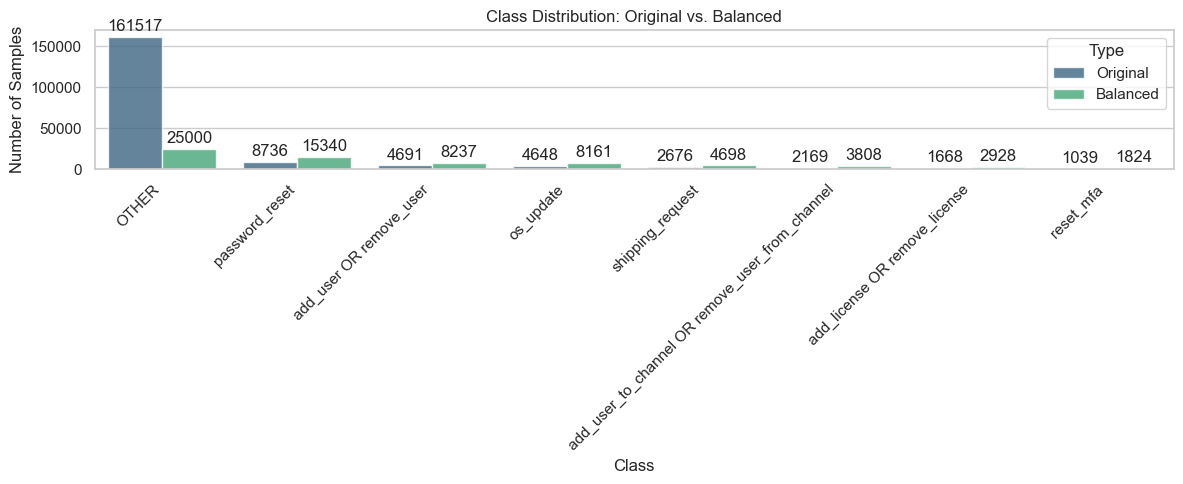

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style for the plots
sns.set_theme(style="whitegrid")

# Function to prepare data for plotting
def prepare_data_for_plot(original_counts, balanced_counts):
    original_df = pd.DataFrame(list(original_counts.items()), columns=['Class', 'Count'])
    original_df['Type'] = 'Original'
    
    balanced_df = pd.DataFrame(list(balanced_counts.items()), columns=['Class', 'Count'])
    balanced_df['Type'] = 'Balanced'
    
    # Combine the two DataFrames
    combined_df = pd.concat([original_df, balanced_df], ignore_index=True)
    return combined_df

# Capture class distributions before and after resampling
counts_before = original_counts  # Use previously calculated original class distribution
counts_after = dict(Counter(y_balanced))  # Calculate balanced class distribution dynamically

# Prepare data for plotting
combined_df = prepare_data_for_plot(counts_before, counts_after)

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(12, 5))
barplot = sns.barplot(
    data=combined_df, 
    x='Class', 
    y='Count', 
    hue='Type', 
    palette='viridis',
    alpha=0.8
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution: Original vs. Balanced')

# Add data labels on top of the bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.0f', label_type='edge', padding=2)

plt.tight_layout()
plt.show()

## **Part 3: Prediction Models**

In [49]:
# Prepare an empty dictionary to store each model's metrics
model_metrics = {}

**1. Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Define the training and evaluation function for Logistic Regression
def train_evaluate_logistic(X_train, X_test, y_train, y_test):
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Convert the predicted integer labels back to original string labels
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    print("Logistic Regression Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    return classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Train and evaluate the Logistic Regression model
metric_lr = train_evaluate_logistic(X_train_bal, X_test_bal, y_train_bal, y_test_bal)

# Store the results in the dictionary
model_metrics['Logistic Regression'] = metric_lr

Logistic Regression Classification Report:
                                                 precision    recall  f1-score   support

                                          OTHER       0.83      0.54      0.66      5000
                  add_license OR remove_license       0.54      0.85      0.66       586
                        add_user OR remove_user       0.67      0.81      0.74      1647
add_user_to_channel OR remove_user_from_channel       0.72      0.92      0.81       762
                                      os_update       0.77      0.90      0.83      1632
                                 password_reset       0.86      0.86      0.86      3068
                                      reset_mfa       0.56      0.90      0.69       365
                               shipping_request       0.64      0.92      0.76       940

                                       accuracy                           0.75     14000
                                      macro avg       0.70      0

**2. Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Convert to 32-bit float
X_train_bal = X_train_bal.astype(np.float32)
X_test_bal = X_test_bal.astype(np.float32)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Trian and evaluate Random Forest model
def train_evaluate_rf(X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier(
        random_state=42,
        n_jobs=-1       # Use all available cores
    )
    grid_search = GridSearchCV(
        rf_model,
        param_grid_rf,
        cv=2,                     # ues 2-fold cross-validation
        scoring='f1_weighted',
        n_jobs=-1                 # Use all available cores
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    # Output the best parameters found
    print("Best Parameters found:")
    print(grid_search.best_params_)

    y_pred = best_model.predict(X_test)
    # Convert the predicted integer labels back to original string labels
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    print("Random Forest Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    # Return the classification report as a dictionary
    return classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Train and evaluate the Random Forest model
metric_rf = train_evaluate_rf(X_train_bal, X_test_bal, y_train_bal, y_test_bal)

# Store the results in the dictionary
model_metrics['RandomForest'] = metric_rf

**3. XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import xgboost as xgb

# Expanded parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 1],
    'min_child_weight': [1, 5]
}

def train_evaluate_xgb(X_train, X_test, y_train, y_test):
    xgb_model = XGBClassifier(
        random_state=42,
        tree_method='hist',        # Use 'hist' tree method
        device='cuda',             # Enable GPU acceleration
        eval_metric='mlogloss',
        max_bin=256,
        n_jobs=1                   # Limit CPU threads
    )
    grid_search = GridSearchCV(
        xgb_model,
        param_grid_xgb,
        cv=2,
        scoring='f1_weighted',
        n_jobs=1                   # Limit CPU threads
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    # Output the best parameters found
    print("Best Parameters found:")
    print(grid_search.best_params_)
    
    # Predictions
    y_pred = best_model.predict(X_test)

    # Convert labels back to original strings
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    print("XGBoost Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    return classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Train and evaluate the XGBoost model
metric_xgb = train_evaluate_xgb(X_train_bal, X_test_bal, y_train_bal, y_test_bal)

# Store the results
model_metrics['XGBoost'] = metric_xgb

**4. LightGBM**

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Ensure data types are float32 to reduce memory usage
X_train_bal = X_train_bal.astype(np.float32)
X_test_bal = X_test_bal.astype(np.float32)

# Use the data without PCA
X_train_bal_reduced = X_train_bal
X_test_bal_reduced = X_test_bal

# Slightly expanded parameter grid
param_grid_lgb = {
    'n_estimators': [100, 200],          # Try different numbers of trees
    'max_depth': [3, 5, 7],              # Add a deeper tree depth
    'learning_rate': [0.1, 0.05],        # Keep existing learning rates
    'num_leaves': [31, 63],              # Try a larger number of leaves
    'subsample': [0.8],                  # Keep subsample constant
    'colsample_bytree': [0.8],           # Keep colsample_bytree constant
    'reg_alpha': [0],                    # Keep reg_alpha constant
    'reg_lambda': [0],                   # Keep reg_lambda constant
    'min_child_samples': [20, 40]        # Try increasing min_child_samples
}

def train_evaluate_lgb(X_train, X_test, y_train, y_test):
    lgb_model = LGBMClassifier(
        random_state=42,
        device='gpu',            # Enable GPU acceleration
        gpu_device_id=0,         # Specify GPU device ID
        n_jobs=1,                # Limit CPU usage
        verbose=-1               # Suppress warnings
    )
    grid_search = GridSearchCV(
        lgb_model,
        param_grid_lgb,
        cv=2,
        scoring='f1_weighted',
        n_jobs=1                 # Limit CPU usage
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Output the best parameters found
    print("Best Parameters found:")
    print(grid_search.best_params_)

    y_pred = best_model.predict(X_test)
    # Convert labels back to original strings
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    print("LightGBM Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    # Return the classification report as a dictionary
    return classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Train and evaluate the LightGBM model
metric_lgb = train_evaluate_lgb(X_train_bal_reduced, X_test_bal_reduced, y_train_bal, y_test_bal)

# Store the results
model_metrics['LightGBM'] = metric_lgb

**5. MLP**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Prepare the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test_bal)

# Convert data to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_bal, dtype=torch.long).to(device)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, num_classes, activation='relu'):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_layer_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# Hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [[100], [200]],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [20]  # Reduced for faster training
}

# Function to train and evaluate the MLP model
def train_evaluate_mlp(X_train, X_test, y_train, y_test):
    num_classes = len(np.unique(y_train_bal))
    input_size = X_train.shape[1]
    best_f1 = 0
    best_params = None
    best_model = None
    
    # Iterate over all combinations of hyperparameters
    from itertools import product
    for hidden_sizes, activation, lr, epochs in product(
        param_grid_mlp['hidden_layer_sizes'],
        param_grid_mlp['activation'],
        param_grid_mlp['learning_rate_init'],
        param_grid_mlp['max_iter']
    ):
        model = MLP(input_size, hidden_sizes, num_classes, activation).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Training loop
        batch_size = 64
        for epoch in range(epochs):
            permutation = torch.randperm(X_train.size()[0])
            model.train()
            for i in range(0, X_train.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x = X_train[indices]
                batch_y = y_train[indices]
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            _, predicted = torch.max(outputs, 1)
            y_pred = predicted.cpu().numpy()
            y_true = y_test.cpu().numpy()
            # Convert labels back to original strings
            y_test_labels = label_encoder.inverse_transform(y_true)
            y_pred_labels = label_encoder.inverse_transform(y_pred)
            report = classification_report(y_test_labels, y_pred_labels, output_dict=True)
            f1_weighted = report['weighted avg']['f1-score']
            if f1_weighted > best_f1:
                best_f1 = f1_weighted
                best_params = {
                    'hidden_layer_sizes': hidden_sizes,
                    'activation': activation,
                    'learning_rate_init': lr,
                    'max_iter': epochs
                }
                best_model = model
    
    # Print best parameters
    print("Best Parameters:", best_params)
    
    # Final evaluation on the test set
    best_model.eval()
    with torch.no_grad():
        outputs = best_model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_pred = predicted.cpu().numpy()
        y_true = y_test.cpu().numpy()
        y_test_labels = label_encoder.inverse_transform(y_true)
        y_pred_labels = label_encoder.inverse_transform(y_pred)
        print("MLP Classification Report:")
        print(classification_report(y_test_labels, y_pred_labels))
        return classification_report(y_test_labels, y_pred_labels, output_dict=True)

# Train and evaluate the MLP model
metric_mlp = train_evaluate_mlp(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor)

# Store the results
model_metrics['MLP'] = metric_mlp

**Compare Results**

In [ ]:
## snowflake embedding
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the f-1 score dictionary to a DataFrame
metrics_df = pd.DataFrame(model_metrics).T

# Define a function to extract F1-scores from the nested dictionary
def extract_f1_scores(value):
    if isinstance(value, dict) and 'f1-score' in value:
        return value['f1-score']
    elif isinstance(value, (int, float)):
        return value
    return None

# use the function to extract f1 scores
f1_scores_df = metrics_df.applymap(extract_f1_scores)

# only keed columns except macro avg	accuracy	weighted avg
f1_scores_df = f1_scores_df.drop(columns=['macro avg', 'accuracy', 'weighted avg'])

# Calculate the average F1-score for each category and sort categories in descending order
average_f1_scores = f1_scores_df.mean(axis=0)
categories_ordered = average_f1_scores.sort_values(ascending=False).index.tolist()

# Update the column order of f1_scores_df
f1_scores_df = f1_scores_df[categories_ordered]

# Set font size to 23, set white background and palette
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 23})

# Use Seaborn color palette, ensuring greater color variation (more distinct bar colors for each category)
palette = sns.color_palette("Oranges", n_colors=len(f1_scores_df.index))

# Reset index and convert to long format
f1_scores_melted = f1_scores_df.reset_index().melt(id_vars='index', var_name='Category', value_name='F1-score')

# Manually set the model order
model_order = ['Logistic Regression', 'XGBoost', 'LightGBM', 'MLP']
f1_scores_melted['index'] = pd.Categorical(f1_scores_melted['index'], categories=model_order, ordered=True)

# Plot the bar chart
plt.figure(figsize=(22, 6))
ax = sns.barplot(data=f1_scores_melted, x='Category', y='F1-score', hue='index', palette=palette, alpha=0.8)

# Set Y-axis and X-axis labels and increase font size
plt.ylabel('F1-score', fontsize=30)
plt.xlabel('SIMPLIFIED_CATEGORY', fontsize=30)
plt.title("This Week's Result", fontsize=28)
plt.xticks(rotation=0, ha='center', fontsize=22)

# Set Y-axis range from 0.5 to 1
plt.ylim(0.5, 1)

# Place the legend inside the plot, set to horizontal layout
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=24, frameon=False)

# Add value labels with reduced font size to 16
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=20)

plt.tight_layout()
plt.show()

## **Part 4: Threshold Method**

**Furthur Finetuning LightGBM**

Changes include:

(1) Shifted tuning goal from F-1 score to precision

(2) Changed parameter search method from grid search to Bayesian Optimization for broader, more flexible parameter selection

In [ ]:
model_precision_scores = {}

import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import numpy as np

# Ensure data types are float32 to reduce memory usage
X_train_bal = X_train_bal.astype(np.float32)
X_test_bal = X_test_bal.astype(np.float32)

# Objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 7, 127),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'random_state': 42,
        'device': 'gpu',
        'gpu_device_id': 0,
        'n_jobs': 1,
        'verbose': -1
    }
    clf = LGBMClassifier(**param)
    return cross_val_score(clf, X_train_bal, y_train_bal, cv=2, scoring='precision_weighted', n_jobs=1).mean()

# Create and run Optuna study
study = optuna.create_study(direction='maximize', study_name='LGBM Precision Optimization')
study.optimize(objective, n_trials=100, timeout=36000)

# Output the best parameters found
print("\nBest Parameters found:", study.best_params)

# Train the best model
best_model = LGBMClassifier(
    **study.best_params,
    random_state=42,
    device='gpu',
    gpu_device_id=0,
    n_jobs=1,
    verbose=-1
)
best_model.fit(X_train_bal, y_train_bal)
y_pred = best_model.predict(X_test_bal)

# Convert labels back to original strings
y_test_labels = label_encoder.inverse_transform(y_test_bal)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Print classification report
print("\nLightGBM Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Save the classification report as a dictionary
precision_scores_lgb = classification_report(y_test_labels, y_pred_labels, output_dict=True)
model_precision_scores['LightGBM'] = precision_scores_lgb

Best Parameters found: {
    'colsample_bytree': 0.7715490096744506,
    'learning_rate': 0.09741465956967921,
    'max_depth': 9,
    'min_child_samples': 37,
    'n_estimators': 169,
    'num_leaves': 90,
    'reg_alpha': 0.09536592999298432,
    'reg_lambda': 0.3981311006973933,
    'subsample': 0.946224464192131,
    'random_state': 42,
    'device': 'gpu',
    'gpu_device_id': 0,
    'n_jobs': 1,
    'verbose': -1
}

**Train LightGBM based on optimal parameters**

In [ ]:
# Define the best parameters from previous optimization
best_params = {
    'colsample_bytree': 0.7715490096744506,
    'learning_rate': 0.09741465956967921,
    'max_depth': 9,
    'min_child_samples': 37,
    'n_estimators': 169,
    'num_leaves': 90,
    'reg_alpha': 0.09536592999298432,
    'reg_lambda': 0.3981311006973933,
    'subsample': 0.946224464192131,
    'random_state': 42,
    'device': 'gpu',
    'gpu_device_id': 0,
    'n_jobs': 1,
    'verbose': -1
}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Ensure data types are float32 to reduce memory usage
X_train_bal = X_train_bal.astype(np.float32)
X_test_bal = X_test_bal.astype(np.float32)

# Train the model using the best parameters
model = LGBMClassifier(**best_params)
model.fit(X_train_bal, y_train_bal)

# Predict probabilities
y_proba = model.predict_proba(X_test_bal)

# Encode labels if needed for consistent indexing
label_encoder = LabelEncoder()
y_test_bal_encoded = label_encoder.fit_transform(y_test_bal)
label_names = label_encoder.inverse_transform(np.unique(y_test_bal_encoded))

In [ ]:
# Manually create label_map
label_map = {
    0: "OTHER",
    1: "add_license OR remove_license",
    2: "add_user OR remove_user",
    3: "add_user_to_channel OR remove_user_from_channel",
    4: "os_update",
    5: "password_reset",
    6: "reset_mfa",
    7: "shipping_request"
}

# Print label_map to verify correctness
for index, label_name in label_map.items():
    print(f"Encoded label {index} corresponds to {label_name}")

Encoded label 0 corresponds to OTHER
Encoded label 1 corresponds to add_license OR remove_license
Encoded label 2 corresponds to add_user OR remove_user
Encoded label 3 corresponds to add_user_to_channel OR remove_user_from_channel
Encoded label 4 corresponds to os_update
Encoded label 5 corresponds to password_reset
Encoded label 6 corresponds to reset_mfa
Encoded label 7 corresponds to shipping_request


In [ ]:
from sklearn.metrics import precision_score, recall_score

y_pred = np.argmax(y_proba, axis=1)
precision = precision_score(y_test_bal_encoded, y_pred, average=None)
recall = recall_score(y_test_bal_encoded, y_pred, average=None)

# Store precision and recall results per label
precision_recall_results = []
for label, name in label_map.items():
    precision_recall_results.append({"Label": name, "Metric": "Precision", "Score": precision[label]})
    precision_recall_results.append({"Label": name, "Metric": "Recall", "Score": recall[label]})

# Calculate overall precision and recall
overall_precision = precision_score(y_test_bal_encoded, y_pred, average="macro")
overall_recall = recall_score(y_test_bal_encoded, y_pred, average="macro")
precision_recall_results.append({"Label": "Overall", "Metric": "Precision", "Score": overall_precision})
precision_recall_results.append({"Label": "Overall", "Metric": "Recall", "Score": overall_recall})
weighted_recall = recall_score(y_test_bal_encoded, y_pred, average="weighted")

**Top Threshold**

In [ ]:
# Enhanced Thresholded Top-N Accuracy and sample output analysis with top_threshold
top_thresholds = np.arange(0.0, 1.001, 0.001)  # 60%-100% with 1% intervals
top_n_choices = [2]
results_overall = {}
two_label_probs = {}

for top_threshold in top_thresholds:
    correct_predictions = []
    label_correct_counts = {label: 0 for label in np.unique(y_test_bal_encoded)}
    label_total_counts = {label: 0 for label in np.unique(y_test_bal_encoded)}
    two_label_count = 0  # Counter for two-label cases for current top_threshold
    
    # Loop through each test instance
    for i in range(len(y_test_bal_encoded)):
        probabilities = y_proba[i]
        true_label = y_test_bal_encoded[i]
        label_total_counts[true_label] += 1
        
        # Identify top-N indices and check if highest probability exceeds top_threshold
        top_n_indices = np.argsort(probabilities)[-2:]
        max_prob = probabilities[top_n_indices[-1]]
        
        # Check correctness and count two-label output
        if max_prob > top_threshold:
            prediction = np.argmax(probabilities)
            is_correct = prediction == true_label
        else:
            is_correct = true_label in top_n_indices
            two_label_count += 1 if len(top_n_indices) == 2 else 0
            
        correct_predictions.append(is_correct)
        if is_correct:
            label_correct_counts[true_label] += 1

    # Calculate overall accuracy and two-label probability
    overall_accuracy = sum(correct_predictions) / len(y_test_bal_encoded)
    two_label_prob = two_label_count / len(y_test_bal_encoded)
    results_overall[top_threshold] = overall_accuracy
    two_label_probs[top_threshold] = two_label_prob

**Gap Threshold**

In [ ]:
# Gap-Threshold analysis for top-1 and top-2 probability differences
gap_thresholds = np.arange(0.0, 1.001, 0.001)  # 10%-90% with 1% intervals
gap_results_overall = {}
gap_two_label_probs = {}

for gap_threshold in gap_thresholds:
    correct_predictions = []
    label_correct_counts = {label: 0 for label in np.unique(y_test_bal_encoded)}
    label_total_counts = {label: 0 for label in np.unique(y_test_bal_encoded)}
    gap_two_label_count = 0  # Counter for two-label cases for current gap threshold
    
    # Loop through each test instance
    for i in range(len(y_test_bal_encoded)):
        probabilities = y_proba[i]
        true_label = y_test_bal_encoded[i]
        label_total_counts[true_label] += 1
        
        # Get top-1 and top-2 probabilities and calculate the difference
        sorted_probs = np.sort(probabilities)
        max_prob, second_max_prob = sorted_probs[-1], sorted_probs[-2]
        prob_gap = max_prob - second_max_prob
        
        # Check correctness and count two-label output based on gap threshold
        if prob_gap > gap_threshold:
            prediction = np.argmax(probabilities)
            is_correct = prediction == true_label
        else:
            is_correct = true_label in np.argsort(probabilities)[-2:]
            gap_two_label_count += 1
        
        correct_predictions.append(is_correct)
        if is_correct:
            label_correct_counts[true_label] += 1

    # Calculate overall accuracy and two-label probability for gap threshold
    overall_accuracy = sum(correct_predictions) / len(y_test_bal_encoded)
    gap_two_label_prob = gap_two_label_count / len(y_test_bal_encoded)
    gap_results_overall[gap_threshold] = overall_accuracy
    gap_two_label_probs[gap_threshold] = gap_two_label_prob

**Save Results**

In [ ]:
# save weighted_recall, top_thresholds, results_overall, two_label_probs, gap_thresholds, gap_results_overall, gap_two_label_probs
np.save('weighted_recall.npy', weighted_recall)
np.save('top_thresholds.npy', top_thresholds)
np.save('results_overall.npy', results_overall)
np.save('two_label_probs.npy', two_label_probs)
np.save('gap_thresholds.npy', gap_thresholds)
np.save('gap_results_overall.npy', gap_results_overall)
np.save('gap_two_label_probs.npy', gap_two_label_probs)

**Plot Results**

Read Results

In [ ]:
import numpy as np

# Load the saved results
weighted_recall = np.load('weighted_recall.npy')
top_thresholds = np.load('top_thresholds.npy')
results_overall = np.load('results_overall.npy', allow_pickle=True).item()
two_label_probs = np.load('two_label_probs.npy', allow_pickle=True).item()
gap_thresholds = np.load('gap_thresholds.npy')
gap_results_overall = np.load('gap_results_overall.npy', allow_pickle=True).item()
gap_two_label_probs = np.load('gap_two_label_probs.npy', allow_pickle=True).item()

Trade-offs by Top Thresholds & Gap Thresholds

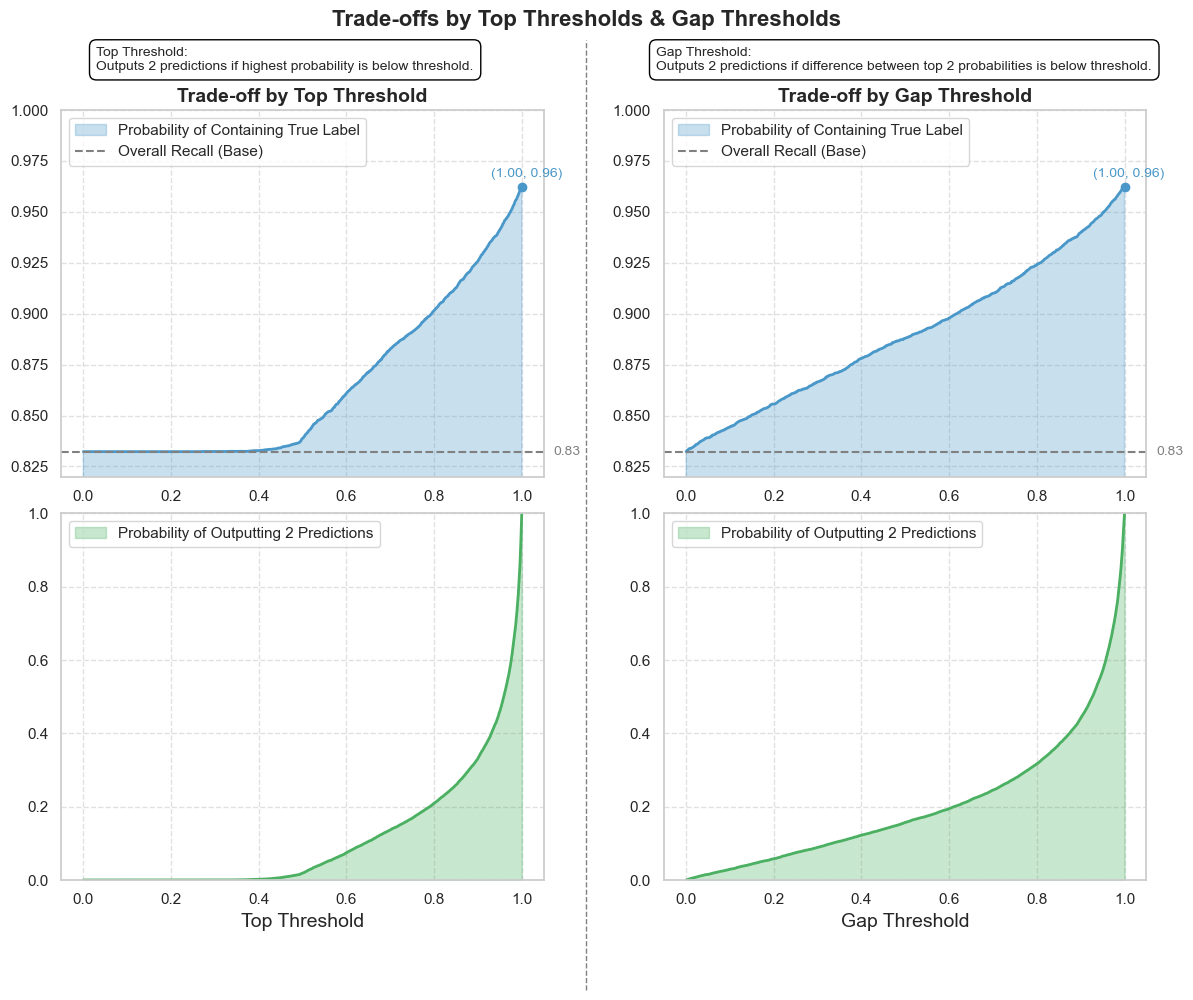

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Set style and color palettes
sns.set_theme(style="whitegrid")
color_inclusive_probability = sns.color_palette("Blues", 4)[2]
color_two_label = sns.color_palette("Greens", 4)[2]
base_line_style = {"color": "gray", "linestyle": "--", "linewidth": 1.5}

# Annotate turning and max points
def annotate_max_point(ax, x, y, color, offset=(0.01, 0.005), threshold=0.02):
    idx = np.argmax(x)
    point_x, point_y = x[idx], y[idx]
    ax.text(point_x + offset[0], point_y + offset[1], f'({point_x:.2f}, {point_y:.2f})', 
            ha='center', fontsize=10, color=color)
    ax.plot(point_x, point_y, 'o', color=color, markersize=6)

# Plot helper function
def plot_curve(ax, x, y, title, xlabel, color, add_hline=False, ylim=None):
    ax.fill_between(x, y, color=color, alpha=0.3)
    ax.plot(x, y, color=color, linewidth=2)
    if add_hline:
        ax.axhline(weighted_recall, **base_line_style)
        ax.text(1.02, weighted_recall, f'{weighted_recall:.2f}', color="gray", va='center', fontsize=10, transform=ax.get_yaxis_transform())
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel(xlabel, fontsize=14)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(True, linestyle="--", alpha=0.6)

# Initialize figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})

# Plot Top Threshold curves
plot_curve(axes[0, 0], top_thresholds, list(results_overall.values()), 
           "Trade-off by Top Threshold", "", color_inclusive_probability, add_hline=True, ylim=(0.82, 1))
annotate_max_point(axes[0, 0], top_thresholds, list(results_overall.values()), color_inclusive_probability)

plot_curve(axes[1, 0], top_thresholds, list(two_label_probs.values()), 
           "", "Top Threshold", color_two_label, ylim=(0, 1))

# Plot Gap Threshold curves
plot_curve(axes[0, 1], gap_thresholds, list(gap_results_overall.values()), 
           "Trade-off by Gap Threshold", "", color_inclusive_probability, add_hline=True, ylim=(0.82, 1))
annotate_max_point(axes[0, 1], gap_thresholds, list(gap_results_overall.values()), color_inclusive_probability)

plot_curve(axes[1, 1], gap_thresholds, list(gap_two_label_probs.values()), 
           "", "Gap Threshold", color_two_label, ylim=(0, 1))

# Add legends
inclusive_patch = Patch(color=color_inclusive_probability, alpha=0.3, label="Probability of Containing True Label")
two_label_patch = Patch(color=color_two_label, alpha=0.3, label="Probability of Outputting 2 Predictions")
base_line = Line2D([], [], **base_line_style, label="Overall Recall (Base)")

for ax, patch in zip([axes[0, 0], axes[0, 1]], [inclusive_patch, inclusive_patch]):
    ax.legend(handles=[patch, base_line], loc="upper left")
for ax in [axes[1, 0], axes[1, 1]]:
    ax.legend(handles=[two_label_patch], loc="upper left")

# Add text for definitions
fig.text(0.15, 0.92, "Top Threshold:\nOutputs 2 predictions if highest probability is below threshold.", 
         ha="left", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))
fig.text(0.55, 0.92, "Gap Threshold:\nOutputs 2 predictions if difference between top 2 probabilities is below threshold.", 
         ha="left", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"))

# Add dividing line
fig.add_artist(plt.Line2D([0.5, 0.5], [0, 0.95], transform=fig.transFigure, color="gray", linestyle="--", linewidth=1))

# Final adjustments
plt.suptitle("Trade-offs by Top Thresholds & Gap Thresholds", fontsize=16, weight='bold')
plt.show()

Simplified Trade-off on only Top Thresholds

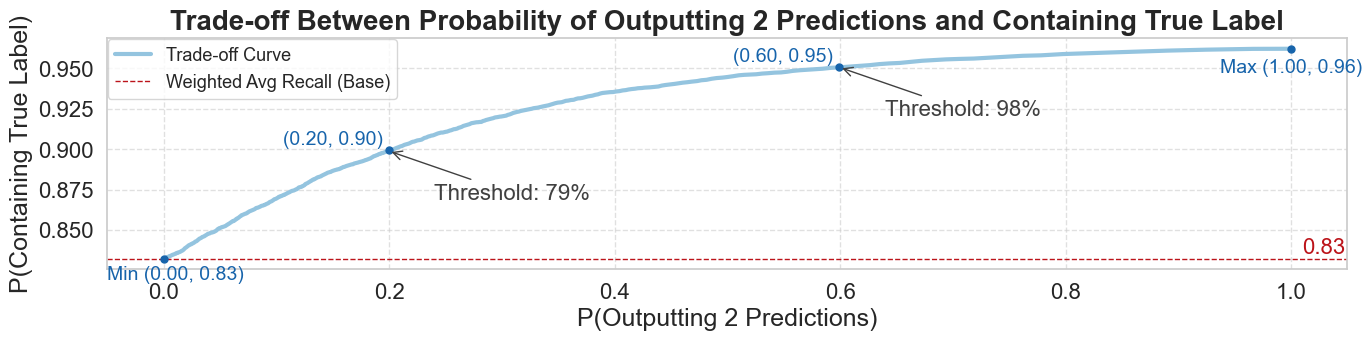

In [ ]:
# Set colors
color_top_threshold = sns.color_palette("Blues", 4)[1]
color_top_threshold_arrow = sns.color_palette("Blues", 4)[3]
common_color = sns.color_palette("Greys", 4)[3]
color_base_line = sns.color_palette("Reds", 4)[3]

# Extract data for Top Threshold
x_values_top = list(two_label_probs.values())  # Probability of Outputting 2 Predictions for Top Threshold
y_values_top = list(results_overall.values())  # Probability of Containing True Label for Top Threshold

# Extract data for Gap Threshold
x_values_gap = list(gap_two_label_probs.values())  # Probability of Outputting 2 Predictions for Gap Threshold
y_values_gap = list(gap_results_overall.values())  # Probability of Containing True Label for Gap Threshold

# Calculate the y-value of the lowest point
min_y_value = min(y_values_top + y_values_gap)

# Create the chart
plt.figure(figsize=(16, 3))

# Plot the Top Threshold curve
plt.plot(x_values_top, y_values_top, color=color_top_threshold, linewidth=3, label="Trade-off Curve")

# Add a gray dashed line passing through the lowest point and add a legend label
plt.axhline(y=min_y_value, color=color_base_line, linestyle="--", linewidth=1, label="Weighted Avg Recall (Base)")

# Add a numeric label of the lowest point dashed line on the right side
plt.text(x_values_top[-1] + 0.01, min_y_value + 0.007, f'{min_y_value:.2f}', ha='left', va='center', color=color_base_line, fontsize=16)

# Annotate points where x-coordinate is 0.2 and 0.6
for x_target in [0.2, 0.6]:
    # Find the points in Top Threshold and Gap Threshold closest to x_target
    idx_top = np.argmin(np.abs(np.array(x_values_top) - x_target))
    idx_gap = np.argmin(np.abs(np.array(x_values_gap) - x_target))

    # Get the corresponding y-values
    x_top, y_top = x_values_top[idx_top], y_values_top[idx_top]
    x_gap, y_gap = x_values_gap[idx_gap], y_values_gap[idx_gap]

    # Find the corresponding value in top_thresholds
    top_threshold_value = top_thresholds[idx_top]

    # Annotate the coordinate and description of the Top Threshold
    plt.annotate(f"Threshold: {top_threshold_value * 100:.0f}%",  # Use the corresponding value from top_thresholds
                 xy=(x_top, y_top), xytext=(x_top + 0.04, y_top - 0.03),
                 arrowprops=dict(arrowstyle="->", color=common_color), color=common_color, fontsize=16)

    # Annotate the coordinate and description of the Gap Threshold
    plt.plot(x_gap, y_gap, 'o', color=color_top_threshold_arrow, markersize=5)
    plt.text(x_gap - 0.05, y_gap + 0.012, f'({x_gap:.2f}, {y_gap:.2f})', ha='center', va='top', fontsize=14, color=color_top_threshold_arrow)

# Add annotations for the minimum and maximum points of Gap Threshold
min_idx_gap = 0
min_x_gap, min_y_gap = x_values_gap[min_idx_gap], y_values_gap[min_idx_gap]
plt.plot(min_x_gap, min_y_gap, 'o', color=color_top_threshold_arrow, markersize=5)
plt.text(min_x_gap + 0.01, min_y_gap - 0.013, f'Min ({min_x_gap:.2f}, {min_y_gap:.2f})', ha='center', color=color_top_threshold_arrow, fontsize=14)

max_idx_gap = len(x_values_gap) - 1
max_x_gap, max_y_gap = x_values_gap[max_idx_gap], y_values_gap[max_idx_gap]
plt.plot(max_x_gap, max_y_gap, 'o', color=color_top_threshold_arrow, markersize=5)
plt.text(max_x_gap, max_y_gap - 0.015, f'Max ({max_x_gap:.2f}, {max_y_gap:.2f})', ha='center', color=color_top_threshold_arrow, fontsize=14)

# Add axis labels and title
plt.xlabel("P(Outputting 2 Predictions)", fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel("P(Containing True Label)", fontsize=18)
plt.yticks(fontsize=16)
plt.title("Trade-off Between Probability of Outputting 2 Predictions and Containing True Label", fontsize=20, weight='bold')

# Add grid and legend
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=13, ncol=1, bbox_to_anchor=(-0.007, 1.035))

# Display the plot
plt.show()

## **Part 5: Application Prediction**

**Upload Data to Snowflake** (Upload the 100 selected conversations to Snowflake)

In [ ]:
import pandas as pd
selected_100 = pd.read_csv('data_application_selected.csv')
write_pandas(conn, selected_100, "SELECTED_APPLICATION_100", auto_create_table=True)

**Use LLM (llama3.1-405b) to Get the Application**

In [ ]:
cur = conn.cursor()

cur.execute("""
CREATE OR REPLACE TABLE APPLICATION_SELECTED_PREDICTION_LLM_405B_100 AS
SELECT 
    CONVERSATION_ID,
    CONVERSATION_CHANNEL,
    MESSAGE_PLUS_TRIAGE,
    SIMPLIFIED_CATEGORY,
    AGENT_LABELED_APPLICATION,
    SNOWFLAKE.CORTEX.COMPLETE('llama3.1-405b',
        CONCAT('Identify the application mentioned in the following conversation.\n
        The application list is: slack,microsoft_one_drive,know_be_4,adobe_stock,microsoft_teams,mural,miro,8_x_8,open_vpn,performyard,one_login,pager_duty,autodesk,contract_works,lever,cisco_webex,15_five,keynote,superhuman,hunter,fellow,envoy,peakon,promoter_io,hello_fax,hubstaff,jira,django,zoom_us,adobe_illustrator,cisco_meraki,lessonly,cloud_app,jump_cloud,intercom,eset,airtable,talk_desk,tech_data,snagit,mixpanel,opsgenie,adobe_after_effects,udemy,bill_com,go_to_meeting,cisco_umbrella,adobe_in_design,twilio,statuspage,bootcamp,grow,unbounce,jazz_hr,malwarebytes,docu_sign,teams_id,dashlane,notion,microsoft_word,loom,zoom_info,adobe_photoshop,lead_iq,bluebeam_revu,backupify,coder_pad,saleshood,blue_jeans,survey_monkey,fountain,ruckus,process_street,freshdesk,chartio,kahoot,speed_curve,microsoft_excel,lastpass,figma,metabase,clubhouse,ping_board,zoom_phone,lattice,datadog,harvest,user_testing,sketch,papyrs,camtasia,product_plan,log_me_in,loopio,text_expander,grasshopper,spanning_backup,egencia,litmus,klipfolio,recruitee,google_calendar,monday_com,adobe_creative_cloud,dropbox_business,microsoft_power_point,perimeter_81,sonic_wall_next_extender,adobe_acrobat,zendesk,greenhouse,connect_wise,box,confluence,wrike,gong,bit_defender,egnyte,crashplan,help_scout,sparkpost,teamwork_projects,whimsical,lucky_orange,drafted,google_mail,microsoft_outlook,google_workspace,kustomer,lucidchart,atlassian,calendly,send_grid,dialpad,pax_8,unifi_ubiquity,boomerang_for_gmail,trip_actions,envato,google_sheets,hello_sign,new_relic,sophos,panda_doc,google_docs,avast,vonage,hubspot,smartsheet,basecamp,sentinel_one,sellerboard,sketchup,frame_io,marketo,invision,thnks,okta,1_password,chrome,google_drive,abacus,adobe_sign,apple_mail,crowd_strike,google_voice,join_me,close_io,evernote,trello,apple_numbers,crowdstrike,canva,pivotal_tracker,outreach,ask_nicely,live_chat,proof_hub,proposify,uber_conference,type_form,microsoft_365,click_up,ring_central,virtru,share_point,expensify,guru,microsoft_one_note,asana,intermedia,google_hangouts,power_bi,google_forms,google_slides,mailchimp,guesty,vmw_fusion,zip_whip,air_call,mix_max,workable,customer_io,sendwithus,on_shape,groove.\n
        The conversation is shown as below:',
        '<conversation>', 
        MESSAGE_PLUS_TRIAGE, 
        '</conversation>, \n', 'Return only the name of the application from the list given. No explanation, no other content, just the application\'s name exactly the same as given in the list. Do not use the name from the conversation, just the name from the list. If you cannot find any application in the conversation, make a guess based on what you think it might be. If you cannot recognize any application from the conversation, return None. Return only one application name from the list that you think is the most likely one being referenced in the conversation.')) as Application
FROM SELECTED_APPLICATION_100
""")

**Download the LLM Results**

In [2]:
# get LLM results for Application
cur = conn.cursor()
cur.execute("""
select * from APPLICATION_SELECTED_PREDICTION_LLM_405B_100
""")

# Fetch all the results from the query
results = cur.fetchall()

# Get the column names from the cursor description
column_names = [desc[0] for desc in cur.description]

# Convert the results into a pandas DataFrame
application_list_online = pd.DataFrame(results, columns=column_names)

In [7]:
application_list_online['APPLICATION'] = application_list_online['APPLICATION'].replace('microsoft_word', 'microsoft_365')
application_list_online['APPLICATION'] = application_list_online['APPLICATION'].replace('microsoft_excel', 'microsoft_365')
application_list_online['APPLICATION'] = application_list_online['APPLICATION'].replace('google_workspace', 'google_mail')

**Calculate the Accuracy**

In [ ]:
#calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(application_list_online['AGENT_LABELED_APPLICATION'], application_list_online['APPLICATION'])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9500
